In [1]:
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import os

First we started by importing the necessary libraries.

In [2]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

We used the `tf.config.experimental.list_physical_devices('GPU')` to check for all the available GPUs. 

We then used the `tf.config.experimental.set_memory_growth` to set the memory growth to true. 

This is done to avoid the memory allocation errors.

# Loading Data

In [3]:
data = tf.keras.utils.image_dataset_from_directory('data')

Found 545 files belonging to 2 classes.


We used the `tf.keras.preprocessing.image_dataset_from_directory` to load the data from the directory.

In [4]:
data.class_names

['TCImages', 'TSImages']

We have two classes of images which are `TCImages` and `TSImages` which are the images generated by the eye tracking device.

The `TCImages` refers to Non-ASD class and `TSImages` refers to ASD class.

In [5]:
data_iterator = data.as_numpy_iterator()

We used the `as_numpy_iterator` to convert the data into numpy array.

In [6]:
batch = data_iterator.next()

Then we loaded the data as batches of 32 images into the `batch` variable.

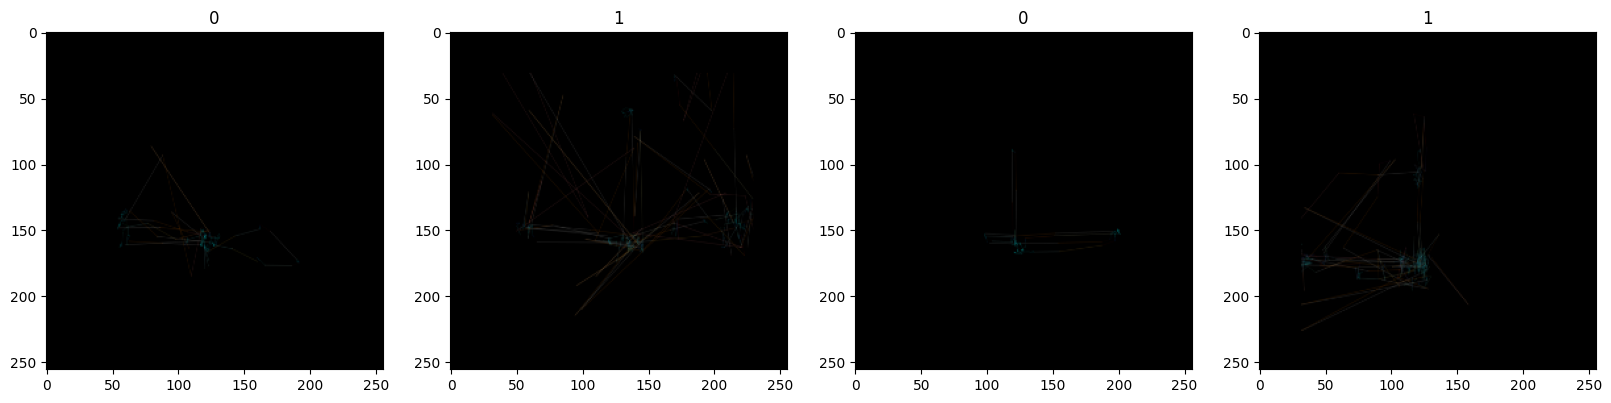

In [10]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

Here we visiualized 4 images of the first batch using the `matplotlib` library.

In [11]:
batch[0].shape

(32, 256, 256, 3)

Each batch of the data consists of 32 images of width and height equal 256 pixels. The images are divided into 3 channels (RGB). The data is loaded using the `tf.data` API.

In [12]:
batch[0].max()

119.78125

Our data is in the range of [0, 255]. We need to scale it to the range of [0, 1] to feed it to the model.

# Scaling The Data

In [13]:
data = data.map(lambda x,y: (x/255, y))

We used the `map` function from the `tf.data` API to scale the data.

In [14]:
scaled_iterator = data.as_numpy_iterator()

In [15]:
batch = scaled_iterator.next()

In [16]:
batch[0].max()

0.47628677

In [17]:
batch[0].min()

0.0

Here we can see that the maximum value of the data is between 1.0 and 0.0 which means that the data is scaled.

Our data is now scaled to the range of [0, 1].

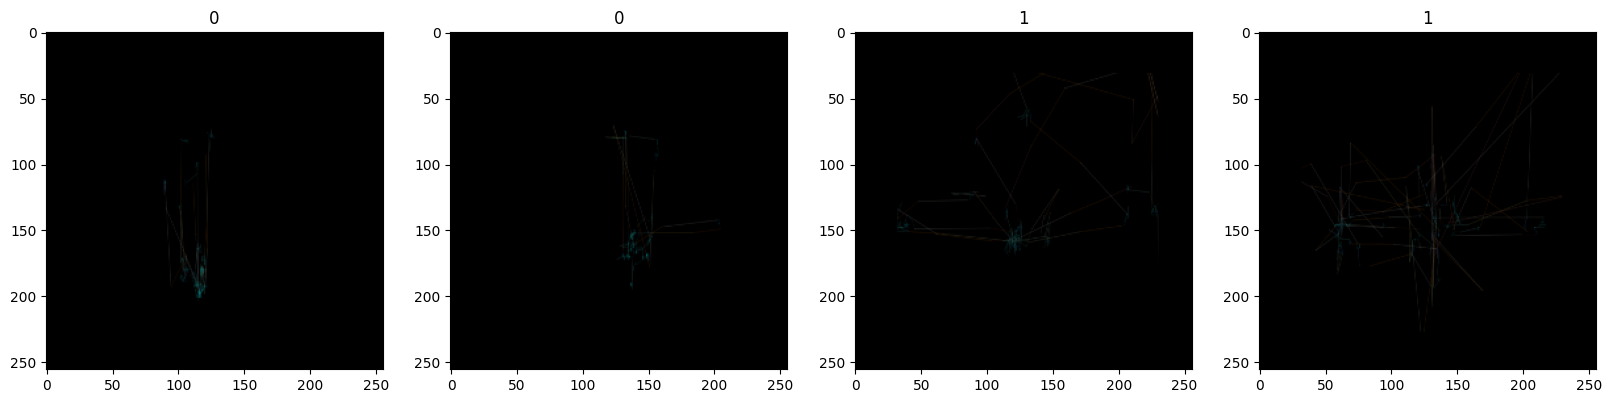

In [18]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img)
    ax[idx].title.set_text(batch[1][idx])

We visiualized the first 4 images of the first batch after scaling to check if the data is scaled correctly.

# Data Augmentation

In [16]:
"""
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.2),
    tf.keras.layers.experimental.preprocessing.RandomContrast(0.2),
])"""

'\ndata_augmentation = tf.keras.Sequential([\n    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),\n    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),\n    tf.keras.layers.experimental.preprocessing.RandomZoom(0.2),\n    tf.keras.layers.experimental.preprocessing.RandomContrast(0.2),\n])'

In [17]:
#augmented_data = data.map(lambda x, y: (data_augmentation(x, training=True), y))

# Spliting The Data

In [18]:
tf.keras.utils.image_dataset_from_directory?

Signature:
tf.keras.utils.image_dataset_from_directory(
    directory,
    labels='inferred',
    label_mode='int',
    class_names=None,
    color_mode='rgb',
    batch_size=32,
    image_size=(256, 256),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False,
    **kwargs,
)
Docstring:
Generates a `tf.data.Dataset` from image files in a directory.

If your directory structure is:

```
main_directory/
...class_a/
......a_image_1.jpg
......a_image_2.jpg
...class_b/
......b_image_1.jpg
......b_image_2.jpg
```

Then calling `image_dataset_from_directory(main_directory,
labels='inferred')` will return a `tf.data.Dataset` that yields batches of
images from the subdirectories `class_a` and `class_b`, together with labels
0 and 1 (0 corresponding to `class_a` and 1 corresponding to `class_b`).

Supported image formats: jpeg, png, bmp, gif.
Animated gifs are truncated to the first frame.

As we see, the shuffle is set to `True` by default in the `tf.keras.utils.image_dataset_from_directory` function 

so we don't need to shuffle the data again and we can directly split it into training, validation and testing sets.

In [19]:
len(data)

18

We have 545 images that are devided into 18 batches , one of them will get turnicated so we are left with 17 batches.

Each batch has 32 images. We will use 12 batches for training, 2 batches for validation and 1 batch for testing.

In [20]:
train_size = 12 #    ≈ 70%
val_size = 2    #    ≈ 20%
test_size = 1   #    ≈ 10%

In [21]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size + val_size).take(test_size)

Here we used the `take` and `skip` methods to split the data, the `take` method takes the data that we specify and the `skip` method skips the data that we already took.

In [22]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip("horizontal_and_vertical",),
  tf.keras.layers.RandomRotation(0.2),
])

In [23]:
aug_train = train.map(lambda x, y: (data_augmentation(x, training=True), y))

In [24]:
len(aug_train), len(val), len(test)

(12, 2, 1)

The batches were assigned correctly to the `training`, `validation` and `testing` sets.

# Building The CNN Model

In [25]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

First we started by importing the Sequential model from the `tf.keras.models` API.

Then we imported the Conv2D, MaxPooling2D, Flatten and Dense layers from the `tf.keras.layers` API.

In [26]:
model = Sequential()

In [27]:
model.add(Conv2D(16, (3, 3), strides=1, padding='same', activation='relu', input_shape=(256, 256, 3)))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3, 3), strides=1, padding='same', activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3, 3), strides=1, padding='same', activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(1, activation='sigmoid'))

We used the `Sequential` model to build our CNN model which is a stack of layers where each layer has exactly one input tensor and one output tensor.

We used three `Conv2D` layer to create a convolutional layer that will generate 16, 32, 16 filters for each image with a kernel size of 3x3 and a stride of 1x1.

We used the `MaxPooling2D` layer to create a pooling layer that will downsample the input representation by taking the maximum value over the window defined by pool_size for each dimension along the features axis.

We used the `Flatten` layer to flatten the input. 

We used the `Dense` layer to create a fully connected layer that will generate 256 neurons.

We used the `Dropout` layer to create a dropout layer that will randomly drop 20% of the neurons to avoid overfitting.

We used the `Dense` layer to create a fully connected layer that will generate 1 neuron with a sigmoid activation function to classify the images into two classes.

In [28]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

We used the `adam` optimizer and the `BinaryCrossentropy()` loss function.

In [29]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 128, 128, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 64, 64, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 32, 32, 16)       

This is the summary of our model.

# Training The Model

In [30]:
logdir='logs'

Here we created a log directory to store the logs of the training process.

In [31]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

We used the `tf.keras.callbacks.TensorBoard` to create a TensorBoard callback to visualize the logs.

In [32]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback], shuffle=True)

Epoch 1/50


12/12 [==============================] - 12s 835ms/step - loss: 0.6555 - accuracy: 0.6224 - val_loss: 0.5389 - val_accuracy: 0.7188
Epoch 2/50
12/12 [==============================] - 11s 858ms/step - loss: 0.5646 - accuracy: 0.7135 - val_loss: 0.4375 - val_accuracy: 0.7969
Epoch 3/50
12/12 [==============================] - 10s 789ms/step - loss: 0.4886 - accuracy: 0.7604 - val_loss: 0.4885 - val_accuracy: 0.7500
Epoch 4/50
12/12 [==============================] - 10s 809ms/step - loss: 0.4704 - accuracy: 0.7760 - val_loss: 0.4797 - val_accuracy: 0.7188
Epoch 5/50
12/12 [==============================] - 10s 789ms/step - loss: 0.4176 - accuracy: 0.7995 - val_loss: 0.3713 - val_accuracy: 0.8750
Epoch 6/50
12/12 [==============================] - 10s 802ms/step - loss: 0.3705 - accuracy: 0.8411 - val_loss: 0.4797 - val_accuracy: 0.7656
Epoch 7/50
12/12 [==============================] - 10s 781ms/step - loss: 0.3554 - accuracy: 0.8594 - val_loss: 0.2682 - val_accuracy: 0.9219
Epoch 8/50

Here we used the `model.fit` function to train the model.

# Plotting Performance

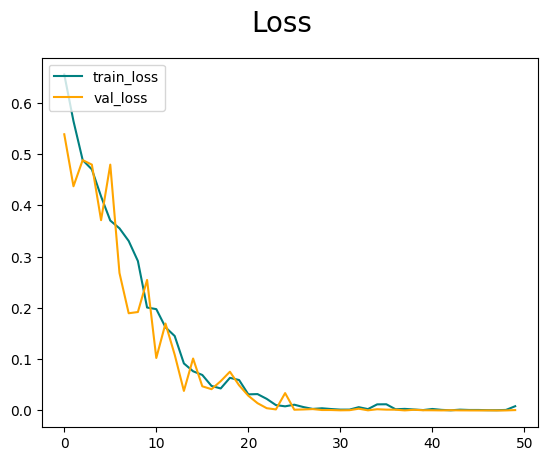

In [33]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='train_loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

Here we used the `matplotlib` library to plot the training and validation loss.

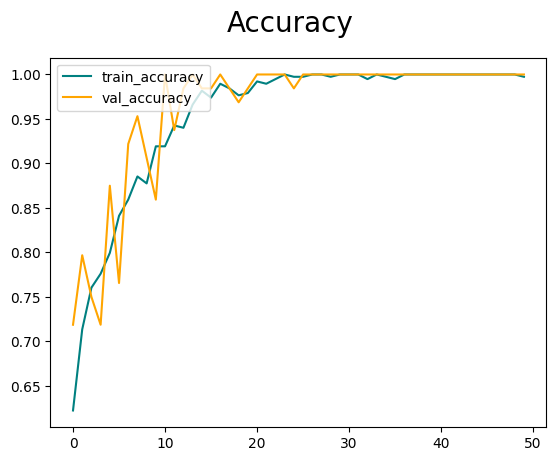

In [34]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='train_accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

And we used the `matplotlib` library again to plot the training and validation accuracy.

# Evaluating The Model

In [35]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy
precision = Precision()
recall = Recall()
accuracy = BinaryAccuracy()

We started our evaluation by importing the `tensorflow.keras.metrics` API.

For the evaluation we will use Precision, Recall and BinaryAccuracy.

In [36]:
precision = Precision()
recall = Recall()
accuracy = BinaryAccuracy()

In [37]:
y_all = []
yhat_all = []

In [38]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)

    y_all = y_all + list(y)
    yhat_all = yhat_all + list(yhat.round())
    
    precision.update_state(y, yhat)
    recall.update_state(y, yhat)
    accuracy.update_state(y, yhat)

1/1 [==============================] - 0s 281ms/step


We used the `model.predict` function to predict the classes of the testing set.

In [39]:
y_all = np.array(y_all)

In [40]:
yhat_all = np.array(yhat_all)

In [41]:
y_all.shape, yhat_all.shape

((32,), (32, 1))

In [42]:
yhat_all = yhat_all.reshape(-1)

In [43]:
yhat_all.shape, y_all.shape

((32,), (32,))

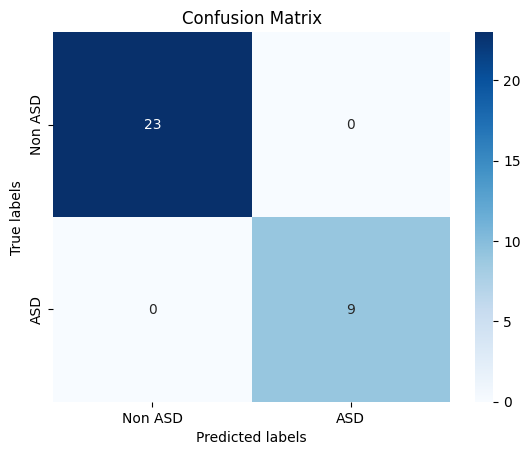

In [44]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Reshape 1D arrays to 2D arrays
y_all = np.array(y_all).reshape(-1, 1)
yhat_all = np.array(yhat_all).reshape(-1, 1)

conf_mat = confusion_matrix(y_all, yhat_all)

ax = plt.subplot()
sns.heatmap(conf_mat, annot=True, fmt='g', ax=ax, cmap='Blues')

# labels, title, and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['Non ASD', 'ASD'])
ax.yaxis.set_ticklabels(['Non ASD', 'ASD'])

plt.show()

We used the `confusion_matrix` function from the sklearn module to create a confusion matrix to evaluate the model.


In [45]:
from sklearn.metrics import classification_report

Then we used the `classification_report` function from the sklearn module to create a classification report to evaluate the model.

In [46]:
print(classification_report(y_all, yhat_all))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        23
           1       1.00      1.00      1.00         9

    accuracy                           1.00        32
   macro avg       1.00      1.00      1.00        32
weighted avg       1.00      1.00      1.00        32



And as we see, the model has a precision of 1.0, a recall of 1.0 and an accuracy of 1.0.

This means that the model has a perfect performance on the testing set.

In [47]:
print(f'Precision:{precision.result().numpy()}, Recall:{recall.result().numpy()}, Accuracy:{accuracy.result().numpy()}')

Precision:1.0, Recall:1.0, Accuracy:1.0


# Testing The Model

Now we will test our model on a new image that we took out of the dataset before beginning the training process to see if our model can classify it correctly.

In [48]:
import cv2

First I started by importing the `cv2` library to read the image.


TypeError: Image data of dtype object cannot be converted to float

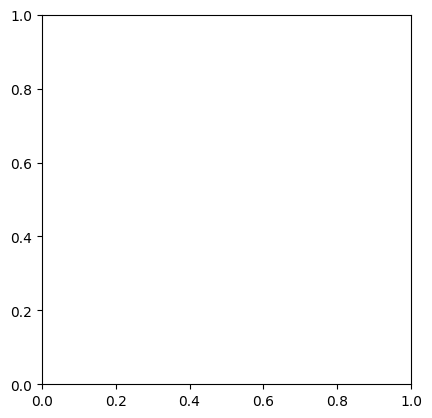

In [49]:
img = cv2.imread('TC082_49.png')
plt.imshow(img)
plt.show()

Then I used the `cv2.imread` function to read the image.

Then i used the `cv2.imshow` function to show the image.


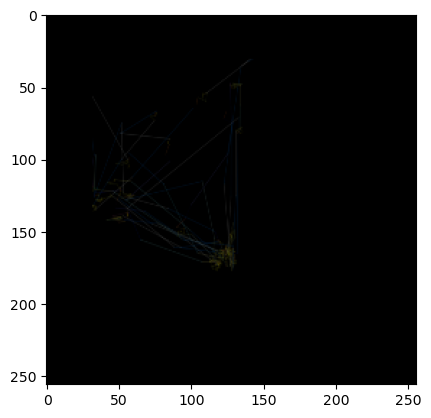

In [ ]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

Then I used the `tf.image.resize()` to resize the image like I did in the scaling step.

In [50]:
yhat = model.predict(np.expand_dims(resize/255, 0))

NameError: name 'resize' is not defined

Here we can see that the image is resized correctly.

Then I used the `np.expand_dims` function to add a new axis to the image.

Then I used the `model.predict` function to predict the class of the image.

In [ ]:
yhat

array([[0.04619177]], dtype=float32)

In [51]:
if yhat > 0.5: 
    print(f'Predicted class is TSI')
else:
    print(f'Predicted class is TCI')

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

Here I used the `if` statement to set the scores to each class.

# Saving the Model

In [ ]:
from tensorflow.keras.models import load_model

Then I called the `load_model` function from the `tensorflow.keras.models` API to load the model.

Then I used the `model.save` function to save the model.    

In [ ]:
model.save(os.path.join('models','imageclassifier.h5'))

c:\Users\Abdul\anaconda3\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


As we can see, the model is saved successfully.

In [ ]:
new_model = load_model('models\imageclassifier.h5')

Here I loaded the model again to make sure that it is saved correctly.

In [ ]:
yhat_new = new_model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 89ms/step


Then I used the `model.predict` function to predict the class of the image again.

In [ ]:
if yhat_new > 0.5: 
    print(f'Predicted class is TSI')
else:
    print(f'Predicted class is TCI')

Predicted class is TCI


And here we can see that everything is working correctly.